In [1]:
import numpy as np
import scipy.io
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
#%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
mat1 = scipy.io.loadmat('Val_Raw_C.mat')
Val_Raw = mat1['Val_Raw']

In [3]:
l,w = 45,35
Total_Val_Photo = int((Val_Raw.shape[0]*Val_Raw.shape[1])/(l*w))
Photo_Val_Col = 18
print(Total_Val_Photo)

2700


In [4]:
#Normalisasi
Val_Raw_Norm = Val_Raw/255

In [5]:
i=0
val_data_raw = np.zeros([Total_Val_Photo,l,w])
for a in range(0,int(Total_Val_Photo/Photo_Val_Col)):
    for b in range(0,Photo_Val_Col):
        val_data_raw[i,:,:] = Val_Raw_Norm[45*a:45+45*a,35*b:35+35*b]
        i=i+1
        
print(val_data_raw.shape)

(2700, 45, 35)


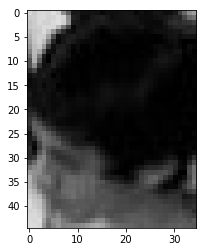

In [6]:
plt.imshow(val_data_raw[1999,:,:], cmap='gray', vmin=0, vmax=1)

In [7]:
tar = np.eye(10)
target_val = np.zeros([Total_Val_Photo,10])
for d in range(0,10):
    target_val[0+int(Total_Val_Photo/10)*d:int(Total_Val_Photo/10)+int(Total_Val_Photo/10)*d,:] = tar[d,:]
print(target_val.shape)

(2700, 10)


In [8]:
tebal_val = Total_Val_Photo
target_val3d = np.zeros(shape=(tebal_val, 1, 10))
i=0
for i in range(tebal_val):
    target_val3d[i,0,:] = target_val[i,:]

In [9]:
def val_inl4d(data):
    image_size = [45,35]
    data4d = np.zeros([Total_Val_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

def val_tarl4d(data):
    image_size = [1,10]
    data4d = np.zeros([Total_Val_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

In [10]:
input_val4d = val_inl4d(val_data_raw)
target_val4d = val_tarl4d(target_val3d)

print(input_val4d.shape)
print(target_val4d.shape)

(2700, 1, 45, 35)
(2700, 1, 1, 10)


In [11]:
device = torch.device('cuda:0')
batch_size_val = int(Total_Val_Photo/10)

In [12]:
input_val4d = torch.from_numpy(input_val4d).float().cuda()
target_val4d = torch.from_numpy(target_val4d).float().cuda()

target_val = torch.from_numpy(target_val).float().cuda()

dataset_val = torch.utils.data.TensorDataset(input_val4d, target_val)

kwargs = {}
val_loader = torch.utils.data.DataLoader(dataset_val,
                                         batch_size=batch_size_val, 
                                         shuffle=True,**kwargs)

print('There are {} images in the test set'.format(len(dataset_val)))
print('There are {} batches in the testloader'.format(len(val_loader)))

There are 2700 images in the test set
There are 10 batches in the testloader


In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(),
            nn.AvgPool2d(kernel_size=5, stride=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=1))
        self.fc1 = nn.Linear(29 * 19 * 50, 1000)
#         self.drop_out = nn.Dropout()
        self.act1 = nn.Tanh()
    
        self.fc2 = nn.Linear(1000, 500)
        self.act2 = nn.Tanh()
        
        self.fc3 = nn.Linear(500,10)
        self.act3 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
#         out = self.drop_out(out)
        out = out.view(-1, 29 * 19 * 50)
        out = self.act1(self.fc1(out))
#         out = self.fc1(out)
        out = self.act2(self.fc2(out))
        out = self.act3(self.fc3(out))
#         out = self.fc3(out)
        return out

In [3]:
model = ConvNet()
model = model.cuda() 
model.load_state_dict(torch.load('CNN_3DFaceRecog_Save_5050_Col.dat'))

In [ ]:
loss_fn = torch.nn.MSELoss(size_average='false').cuda()
print(model)
for p in model.parameters():
    print(p.size())

In [ ]:
#Validasi CNN
val_loss = []
val_accuracy = []
    
#Validasi    
loss_iter_val = 0.0
benar_val = 0
salah_val = 0
iterations = 0
    
model.eval()
    
for i, (inputs, labels) in enumerate(val_loader):
    inputs = Variable(inputs)
    labels = Variable(labels)
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    loss_v = loss_fn(outputs, labels)
    loss_iter_val = loss_iter_val+loss_v.item()
    outputs_recog = torch.round(outputs)
    labels_recog = torch.round(labels)
    for hitung in range(batch_size_val):
        if torch.equal(outputs_recog[hitung,:], labels_recog[hitung,:]):
            benar_val = benar_val + 1
        else:
            salah_val = salah_val + 1
    iterations = iterations + 1
    
recognition_rate_v = (benar_val/Total_Val_Photo)*100
val_accuracy.append(recognition_rate_v)
val_loss.append(loss_iter_val)
    
print ('Validation Loss: {:.7f}, Validation Acc: {:.3f}, Benar: {}, Salah: {}'
       .format(val_loss[-1],
               val_accuracy[-1],
               benar_val,
               salah_val))

In [4]:
transforms_photo = transforms.Compose([transforms.Resize((45,35)),
                                       transforms.ToTensor()])

In [5]:
#Prediksi Manual
def predict(img_name, model):
    image = Image.open(img_name).convert("L")
    image = transforms_photo(image)
    image = image.view(1,1,45,35)
    image = Variable(image)
    
    model.eval()
    model = model.cuda()
    image = image.cuda()
    output = model(image)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    return  predicted.item()

In [9]:
pred = predict('foto_random/sepuluh.jpg', model)
print("The Predicted Person is Person {}".format(pred+1))

tensor([[1.1033e-04, 3.7039e-03, 6.4951e-04, 2.7327e-04, 4.9461e-05, 1.5539e-05,
         1.8230e-04, 2.3074e-03, 9.1119e-03, 9.8779e-01]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor([[1.1033e-04, 3.7039e-03, 6.4951e-04, 2.7327e-04, 4.9461e-05, 1.5539e-05,
         1.8230e-04, 2.3074e-03, 9.1119e-03, 9.8779e-01]], device='cuda:0')
The Predicted Person is Person 10


# Fitur Extraction

Sequential(
  (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
)


c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


torch.Size([1, 10, 40, 30])


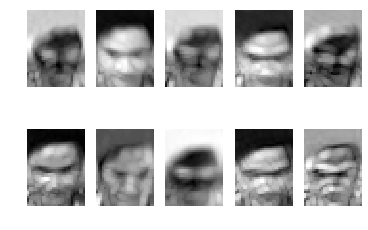

In [4]:
CLayer1=nn.Sequential(nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=1))
print(CLayer1)
image = Image.open('foto_random/5.jpg').convert("L")
image = transforms_photo(image)
image = image.view(1,1,45,35)
image = Variable(image)
cobavar = Variable(image, volatile=True)
image.size()
fe_value = CLayer1(cobavar)
print(fe_value.shape)
for i in range(10):
    plt.subplot(2,5,i+1);plt.imshow(fe_value[0,i,:,:].cpu().detach().numpy(),cmap='gray');plt.axis('off')

Sequential(
  (0): Conv2d(10, 30, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
)


c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


torch.Size([1, 30, 37, 27])


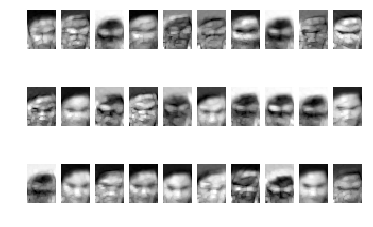

In [6]:
CLayer2=nn.Sequential(
            nn.Conv2d(10, 30, kernel_size=3, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=1)
)
print(CLayer2)
image = fe_value
image = image.view(1,10,40,30)
image = image.cpu()
cobavar = Variable(image, volatile=True)
image.size()
fe_value1 = CLayer2(cobavar)
print(fe_value1.shape)
for i in range(30):
    plt.subplot(3,10,i+1);plt.imshow(fe_value1[0,i,:,:].cpu().detach().numpy(),cmap='gray');plt.axis('off')

Sequential(
  (0): Conv2d(30, 50, kernel_size=(3, 3), stride=(1, 1))
)
torch.Size([1, 50, 35, 25])


c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


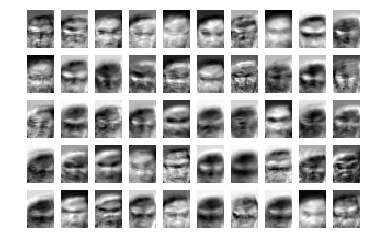

In [7]:
CLayer3=nn.Sequential(
            nn.Conv2d(30, 50, kernel_size=3, stride=1, padding=0)
#            nn.AvgPool2d(kernel_size=2, stride=1)
)
print(CLayer3)
image = fe_value1
image = image.view(1,30,37,27)
image = image.cpu()
cobavar = Variable(image, volatile=True)
image.size()
fe_value2 = CLayer3(cobavar)
print(fe_value2.shape)
for i in range(50):
    plt.subplot(5,10,i+1);plt.imshow(fe_value2[0,i,:,:].cpu().detach().numpy(),cmap='gray');plt.axis('off')

In [7]:
fname = 'foto_random/weighted_gray.jpg'
image1 = Image.open(fname).convert("L")
gambar = np.asarray(image1)

In [8]:
gambar.shape

(210, 338)

(-0.5, 337.5, 209.5, -0.5)

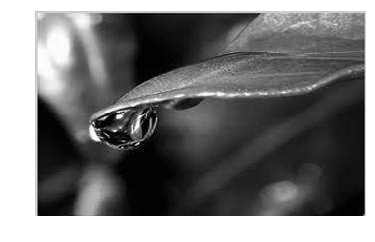

In [25]:
plt.imshow(gambar, cmap = 'gray', vmin=0, vmax=255);plt.axis('off')

In [13]:
transforms_photo1 = transforms.Compose([transforms.Resize((210,338)),
                                       transforms.ToTensor()])

Sequential(
  (0): MaxPool2d(kernel_size=8, stride=1, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([1, 1, 203, 331])


c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


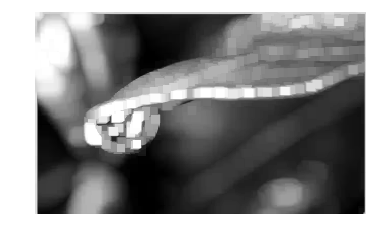

In [24]:
CLayer1=nn.Sequential(nn.MaxPool2d(kernel_size=8, stride=1)
                     )
print(CLayer1)
image = Image.open('foto_random/weighted_gray.jpg').convert("L")
image = transforms_photo1(image)
image = image.view(1,1,210,338)
image = Variable(image)
cobavar = Variable(image, volatile=True)
image.size()
fe_value = CLayer1(cobavar)
print(fe_value.shape)
for i in range(1):
    plt.subplot(1,1,i+1);plt.imshow(fe_value[0,i,:,:].cpu().detach().numpy(),cmap='gray');plt.axis('off')

Text(0, 0.5, 'Akurasi rata-rata (%)')

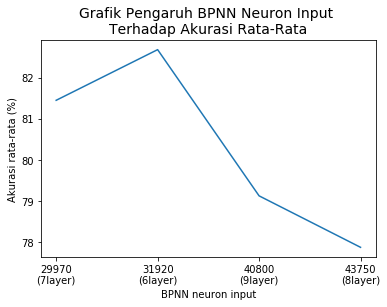

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# create 1000 equally spaced points between -10 and 10
x = ["29970\n(7layer)", "31920\n(6layer)", "40800\n(9layer)", "43750\n(8layer)"]

# calculate the y value for each element of the x vector
y = [81.45, 82.68, 79.13, 77.88]

plt.plot(x, y)
plt.title('Grafik Pengaruh BPNN Neuron Input \nTerhadap Akurasi Rata-Rata', fontsize=14)
plt.xlabel('BPNN neuron input')
plt.ylabel("Akurasi rata-rata (%)")

In [30]:
txt = '7layer', '6layer', '9layer', '8layer'

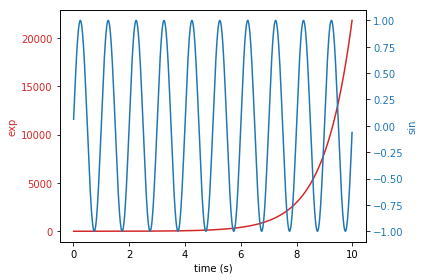

In [15]:
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Neuron Input Klasifikasi')
ax1.set_ylabel("Akurasi rata-rata (%)", color=color)
ax1.plot(x, y, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()